In [2]:
%pip install fredapi

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\wfpin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
%pip install dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# imports for managing env variables/API keys
import os
from dotenv import load_dotenv

In [2]:
# import libraries
import pandas as pd
from fredapi import Fred

In [3]:
load_dotenv()

api_key = os.getenv("API_KEY")
fred = Fred(api_key=api_key)

In [4]:
# search through FRED database
fred.search('Imports', limit=10, order_by='search_rank')

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
IMPGS,IMPGS,2025-04-09,2025-04-09,Imports of Goods and Services,1947-01-01,2024-10-01,Quarterly,Q,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2025-03-27 08:02:02-05:00,53,BEA Account Code: B021RC A Guide to the Natio...
IMPGSA,IMPGSA,2025-04-09,2025-04-09,Imports of Goods and Services,1929-01-01,2024-01-01,Annual,A,Billions of Dollars,Bil. of $,Not Seasonally Adjusted,NSA,2025-03-27 08:00:32-05:00,21,BEA Account Code: B021RC
IEAMGSN,IEAMGSN,2025-04-09,2025-04-09,Imports of goods and services,1999-01-01,2024-10-01,Quarterly,Q,Millions of Dollars,Mil. of $,Not Seasonally Adjusted,NSA,2025-03-20 09:30:04-05:00,17,None
IEAMGS,IEAMGS,2025-04-09,2025-04-09,Imports of goods and services,1999-01-01,2024-10-01,Quarterly,Q,Millions of Dollars,Mil. of $,Seasonally Adjusted,SA,2025-03-20 09:30:04-05:00,8,None
IEAMGSA,IEAMGSA,2025-04-09,2025-04-09,Imports of goods and services,1999-01-01,2024-01-01,Annual,A,Millions of Dollars,Mil. of $,Not Seasonally Adjusted,NSA,2025-03-20 09:30:08-05:00,5,None
NA000342Q,NA000342Q,2025-04-09,2025-04-09,Imports of Goods and Services,1947-01-01,2024-10-01,Quarterly,Q,Millions of Dollars,Mil. of $,Not Seasonally Adjusted,NSA,2025-03-27 08:02:33-05:00,4,BEA Account Code: NA000342
NC000342Q,NC000342Q,2025-04-09,2025-04-09,Imports of Goods and Services,2002-01-01,2024-10-01,Quarterly,Q,Index 2017=100,Index 2017=100,Not Seasonally Adjusted,NSA,2025-03-27 08:02:30-05:00,2,BEA Account Code: NC000342
IR,IR,2025-04-09,2025-04-09,Import Price Index (End Use): All Commodities,1982-09-01,2025-02-01,Monthly,M,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2025-03-18 07:37:50-05:00,51,"For more information, please see the Import/Ex..."
IMPGSC1,IMPGSC1,2025-04-09,2025-04-09,Real imports of goods and services,1947-01-01,2024-10-01,Quarterly,Q,Billions of Chained 2017 Dollars,Bil. of Chn. 2017 $,Seasonally Adjusted Annual Rate,SAAR,2025-03-27 08:03:25-05:00,44,BEA Account Code: A021RX A Guide to the Natio...


In [5]:
def convert_monthly_to_quarterly(df):
    """
    Convert monthly data to quarterly data by taking the mean of each quarter
    """
    df.index = pd.to_datetime(df.index)
    quarterly_df = df.resample('Q').mean()

    # set index to be start of the quarter
    quarterly_df.index = quarterly_df.index + pd.Timedelta(days=1) 

    # entries must drop the first observation due to resampling
    return quarterly_df.tail(-1)

In [6]:
def filter_years(df, year):
    """
    Filter the data to only inlcude entries past a certain year
    """

    # must drop first observation to match quarterly data
    return df[df.index.year >= year].tail(-1)


In [7]:
def convert_to_df(data, name):
    """
    Convert Pandas Series from FRED to Pandas DataFrame
    """
    data.name = name
    data = pd.DataFrame(data)
    data.index.name = 'Date'
    data.reset_index(inplace=True)
    return data

In [8]:
# get the GDP data

# quarterly GDP data
GDP = fred.get_series_latest_release('GDP')

# filter GDP to after 1968 to match CPI data
GDP = filter_years(GDP, 1968)

GDP = convert_to_df(GDP, 'GDP')
GDP.tail(10)

,Date,GDP
217,2022-07-01,26272.011
218,2022-10-01,26734.277
219,2023-01-01,27164.359
220,2023-04-01,27453.815
221,2023-07-01,27967.697
222,2023-10-01,28296.967
223,2024-01-01,28624.069
224,2024-04-01,29016.714
225,2024-07-01,29374.914
226,2024-10-01,29723.864


In [9]:
# get the CPI data
Core_CPI = fred.get_series_latest_release('CORESTICKM159SFRBATL')

# filter CPI to quarterly data
Core_CPI = convert_monthly_to_quarterly(Core_CPI)

# drop the last two observations to match GDP data
Core_CPI = Core_CPI.head(-2)

Core_CPI = convert_to_df(Core_CPI, 'Core CPI')
Core_CPI.tail(10)

C:\Users\wfpin\AppData\Local\Temp\ipykernel_21892\3130277066.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_df = df.resample('Q').mean()


,Date,Core CPI
217,2022-07-01,5.022476
218,2022-10-01,5.963509
219,2023-01-01,6.430481
220,2023-04-01,6.468520
221,2023-07-01,5.945127
222,2023-10-01,5.176014
223,2024-01-01,4.710545
224,2024-04-01,4.501388
225,2024-07-01,4.312833
226,2024-10-01,4.101509


In [10]:
# get unemployment rate data
Unemployment_Rate = fred.get_series_latest_release('UNRATE')

# filter to be quarterly data and be after 1968
Unemployment_Rate = convert_monthly_to_quarterly(Unemployment_Rate)
Unemployment_Rate = filter_years(Unemployment_Rate, 1968)

# drop the last two observations to match GDP data
Unemployment_Rate = Unemployment_Rate.head(-2)
Unemployment_Rate = convert_to_df(Unemployment_Rate, 'Unemployment Rate')
Unemployment_Rate.tail(10)

C:\Users\wfpin\AppData\Local\Temp\ipykernel_21892\3130277066.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_df = df.resample('Q').mean()


,Date,Unemployment Rate
217,2022-07-01,3.633333
218,2022-10-01,3.533333
219,2023-01-01,3.566667
220,2023-04-01,3.533333
221,2023-07-01,3.533333
222,2023-10-01,3.666667
223,2024-01-01,3.800000
224,2024-04-01,3.833333
225,2024-07-01,4.000000
226,2024-10-01,4.166667


In [11]:
# get Fed Funds rate data
FFR = fred.get_series_latest_release('DFF')

# filter to be quarterly data and be after 1968
FFR = convert_monthly_to_quarterly(FFR)
FFR = filter_years(FFR, 1968)

# drop the last three observations to match GDP data
FFR = FFR.head(-3)
FFR = convert_to_df(FFR, 'Fed Funds Rate')
FFR.tail(10)

C:\Users\wfpin\AppData\Local\Temp\ipykernel_21892\3130277066.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_df = df.resample('Q').mean()


,Date,Fed Funds Rate
217,2022-07-01,0.766813
218,2022-10-01,2.182935
219,2023-01-01,3.653370
220,2023-04-01,4.514556
221,2023-07-01,4.988132
222,2023-10-01,5.259239
223,2024-01-01,5.330000
224,2024-04-01,5.330000
225,2024-07-01,5.330000
226,2024-10-01,5.264783


In [12]:
# get government expenditures
Gov_Expenditures = fred.get_series_latest_release('FGEXPND')

# filter to be quarterly data and be after 1968
Gov_Expenditures = convert_monthly_to_quarterly(Gov_Expenditures)           
Gov_Expenditures = filter_years(Gov_Expenditures, 1968)

# drop the last observation to match GDP data
Gov_Expenditures = Gov_Expenditures.head(-1)
Gov_Expenditures = convert_to_df(Gov_Expenditures, 'Gov Expenditures')
Gov_Expenditures.tail(10)

C:\Users\wfpin\AppData\Local\Temp\ipykernel_21892\3130277066.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_df = df.resample('Q').mean()


,Date,Gov Expenditures
217,2022-07-01,6068.545
218,2022-10-01,6181.478
219,2023-01-01,6317.107
220,2023-04-01,6409.685
221,2023-07-01,6444.696
222,2023-10-01,6527.403
223,2024-01-01,6619.838
224,2024-04-01,6772.827
225,2024-07-01,6864.587
226,2024-10-01,7052.115


In [13]:
# get import data

# quarterly import data
Imports = fred.get_series_latest_release('IMPGS')

# filter to be after 1968   
Imports = filter_years(Imports, 1968)
Imports = convert_to_df(Imports, 'Imports')
Imports.tail(10)

,Date,Imports
217,2022-07-01,3988.447
218,2022-10-01,3897.402
219,2023-01-01,3874.210
220,2023-04-01,3799.003
221,2023-07-01,3843.132
222,2023-10-01,3882.899
223,2024-01-01,3966.989
224,2024-04-01,4061.192
225,2024-07-01,4163.975
226,2024-10-01,4141.013


In [14]:
# get export data

# quarterly export data
Exports = fred.get_series_latest_release('EXPGS')

# filter to be after 1968
Exports = filter_years(Exports, 1968)
Exports = convert_to_df(Exports, 'Exports')
Exports.tail(10)

,Date,Exports
217,2022-07-01,3102.550
218,2022-10-01,3046.718
219,2023-01-01,3060.562
220,2023-04-01,2995.524
221,2023-07-01,3062.041
222,2023-10-01,3091.748
223,2024-01-01,3125.421
224,2024-04-01,3154.321
225,2024-07-01,3220.292
226,2024-10-01,3220.929


In [15]:
# merge data along date index
data = pd.merge(Imports, Exports, on='Date')
data = pd.merge(data, Unemployment_Rate, on='Date')
data = pd.merge(data, FFR, on='Date')   
data = pd.merge(data, Gov_Expenditures, on='Date')
data = pd.merge(data, Core_CPI, on='Date')
data = pd.merge(data, GDP, on='Date')
data = data.set_index('Date')
data.reset_index(inplace=True)
data.tail(10)

,Date,Imports,Exports,Unemployment Rate,Fed Funds Rate,Gov Expenditures,Core CPI,GDP
217,2022-07-01,3988.447,3102.550,3.633333,0.766813,6068.545,5.022476,26272.011
218,2022-10-01,3897.402,3046.718,3.533333,2.182935,6181.478,5.963509,26734.277
219,2023-01-01,3874.210,3060.562,3.566667,3.653370,6317.107,6.430481,27164.359
220,2023-04-01,3799.003,2995.524,3.533333,4.514556,6409.685,6.468520,27453.815
221,2023-07-01,3843.132,3062.041,3.533333,4.988132,6444.696,5.945127,27967.697
222,2023-10-01,3882.899,3091.748,3.666667,5.259239,6527.403,5.176014,28296.967
223,2024-01-01,3966.989,3125.421,3.800000,5.330000,6619.838,4.710545,28624.069
224,2024-04-01,4061.192,3154.321,3.833333,5.330000,6772.827,4.501388,29016.714
225,2024-07-01,4163.975,3220.292,4.000000,5.330000,6864.587,4.312833,29374.914
226,2024-10-01,4141.013,3220.929,4.166667,5.264783,7052.115,4.101509,29723.864


In [16]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


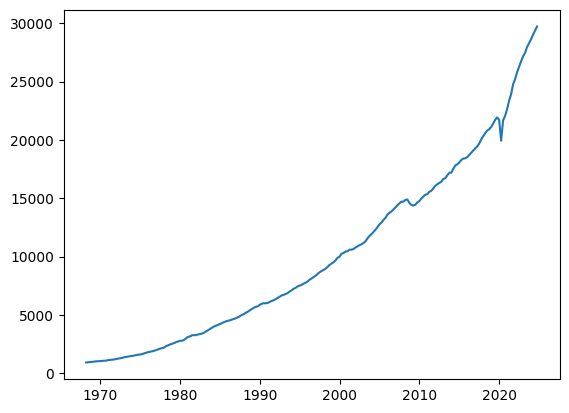

In [26]:
import matplotlib.pyplot as plt
plt.plot(data['Date'], data['GDP'])

In [ ]:
# first train an autoregressive model and examine the model
from statsmodels.tsa.ar_model import AutoReg

In [68]:
# number of lags
p = 4

# fit the autoregressive model - p = 4 generates the lowest MSE during training
# as well as the lowest AIC
model1 = AutoReg(data['GDP'], lags=p, seasonal=False, trend='c').fit()
out = 'AIC: {:.3f}'
print(out.format(model1.aic))

# check mse
predictions = model1.predict(start=p, end=len(data)-1)
print(((data['GDP'].iloc[p:] - predictions)**2).mean())

AIC: 3030.943
38056.40415810973


In [69]:
# now try a more complex model with more variables - ARIMAX
# see if it performs better than the autoregressive model

# first check for stationarity of the data
from statsmodels.tsa.stattools import adfuller
print('p-value:', adfuller(data['GDP'])[1])

p-value: 1.0


In [72]:
# determine d value
# try differencing by 1
d1 = data['GDP'].diff().dropna()
print('p-value:', adfuller(d1)[1])

p-value: 0.003948120143373456


In [74]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

In [100]:
# data preprocessing of exogenous variables
exogenous_vars = data.drop(columns=['Date', 'GDP'])

# standardize exogenous variables
def standardize(data):
    return (data - data.mean()) / data.std()
for col in exogenous_vars.columns:
    exogenous_vars[col] = standardize(exogenous_vars[col])
exogenous_vars.head()

,Imports,Exports,Unemployment Rate,Fed Funds Rate,Gov Expenditures,Core CPI
0,-1.120256,-1.126773,-1.306673,-0.049957,-1.095122,-0.189483
1,-1.117925,-1.123857,-1.402430,0.261270,-1.091743,-0.025030
2,-1.117983,-1.124686,-1.421581,0.251407,-1.090385,0.206171
3,-1.121586,-1.130114,-1.498186,0.243998,-1.088281,0.410264
4,-1.114269,-1.119703,-1.498186,0.413576,-1.089396,0.576108


In [ ]:
# my hypothesis is that a moving average/lag of a multiple of 4
# will be best to account for yearly trends in the quarterly GDP data

# unsurprisingly, the ARIMAX model performs better than the autoregressive model
# ARIMAX AIC = 2689.045
# AR AIX = 3030.943

# test different p and q values and save the one with lowest AIC
AIC = np.inf
for p in range(4,21, 4):
    for q in range(4, 21, 4):
        model = ARIMA(data['GDP'], exog=exogenous_vars, order=(p, 1, q)).fit()
        print('p:', p, 'q:', q, 'AIC:', model.aic)
        if model.aic < AIC:
            AIC = model.aic
            best_p = p
            best_q = q
            best_model = model
print('Best p:', best_p, 'Best q:', best_q, 'AIC:', AIC)
print('Best Model:', best_model.summary())

C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressi

p: 4 q: 4 AIC: 2689.045058173846


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4 q: 8 AIC: 2693.274119848449


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4 q: 12 AIC: 2697.4251213035227


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4 q: 16 AIC: 2696.087211689214


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 4 q: 20 AIC: 2694.998517167646


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 8 q: 4 AIC: 2693.0594180076723


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 8 q: 8 AIC: 2696.825014137297


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 8 q: 12 AIC: 2703.497425545034


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 8 q: 16 AIC: 2706.0747581628434


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 8 q: 20 AIC: 2706.715275998785


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 12 q: 4 AIC: 2696.055014039878


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 12 q: 8 AIC: 2701.4007991529797


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 12 q: 12 AIC: 2706.0760564776997


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 12 q: 16 AIC: 2713.932961268785


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:

p: 12 q: 20 AIC: 2710.0306641524844


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 16 q: 4 AIC: 2696.9011776656907


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 16 q: 8 AIC: 2697.9444853627256


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 16 q: 12 AIC: 2705.8568765594173


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 16 q: 16 AIC: 2717.6194691186556


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 16 q: 20 AIC: 2713.119246827875


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 20 q: 4 AIC: 2697.739449511021


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 20 q: 8 AIC: 2703.0817741308692


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 20 q: 12 AIC: 2711.802071771053


C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 20 q: 16 AIC: 2715.764034045882
p: 20 q: 20 AIC: 2718.2343443246764
Best p: 4 Best q: 4 AIC: 2689.045058173846
Best Model:                                SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  227
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -1329.523
Date:                Wed, 09 Apr 2025   AIC                           2689.045
Time:                        22:22:48   BIC                           2740.353
Sample:                             0   HQIC                          2709.751
                                - 227                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Imports             -95.0409    132.883     -0.715      0.474    -355.

C:\Users\wfpin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
